### Setup

In [1]:
import pandas as pd
import numpy as np
import os
from time import time

In [2]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars,LassoLarsCV
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [3]:
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV

In [4]:
#import sys
#sys.path.append(os.path.abspath('..'))#sys.path[0] + '/..') 
from vb_estimators import LinRegSupreme,LinSVR,RBFSVR,ENet,L1Lars,GBR,HGBR,FlexiblePipe
from vb_helper import VBHelper
from vb_cross_validator import regressor_q_stratified_cv

no daal4py


In [5]:

from warnings import filterwarnings
filterwarnings('ignore')


In [6]:
gridpoints=5
kwargs=dict(
    test_share=0.2,
    cv_folds=10,
    cv_reps=10,
    cv_groupcount=10,
    cv_strategy='quantile', #'none',# for stratified cv
    random_state=2 # random_state for reproducibility
)
vbhelper=VBHelper(**kwargs)

In [7]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
vbhelper.scorer_list=scorer_list

##### Example Dataset

In [8]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [9]:
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]
X_df=df.loc[:,x_vars]
y_df=df.loc[:,y_name]

In [10]:

shuf=np.arange(y_df.shape[0])
np.random.seed(0)
np.random.shuffle(shuf)
X_df=X_df.iloc[shuf]
y_df=y_df.iloc[shuf]
vbhelper.setData(X_df,y_df)
X_train, X_test, y_train, y_test=vbhelper.train_test_split()

(0, 1, 2, 3) ('YEAR', 'SEASON', 'SUBAREA', 'HABCODE')


In [11]:
est_kwargs=dict(gridpoints=gridpoints,cat_idx=vbhelper.cat_idx,float_idx=vbhelper.float_idx,bestT=False)
estimator_dict={
    
    'powXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'powXB'}),
    'expXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'expXB'}), #expXB is default
    'nonlinear-search-least-sq': lambda:FlexiblePipe(**est_kwargs,functional_form_search=True),
    'robust-powXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'powXB','robust':True}),
    'robust-expXB-least-sq':lambda:FlexiblePipe(**est_kwargs,flex_kwargs={'form':'expXB','robust':True}), #expXB is default
    'robust-nonlinear-search-least-sq': lambda:FlexiblePipe(**est_kwargs,functional_form_search=True,flex_kwargs={'robust':True}),
    #'histogram-gradient-boosting-reg':HGBR,
    'gradient-boosting-reg':GBR,
    #'lin-reg-supreme':lambda: LinRegSupreme(**est_kwargs),
    #'elastic-net':lambda: ENet(**est_kwargs), 
    #'linear-svr-cv':lambda: LinSVR(**est_kwargs), 
    'rbf-svr-cv':lambda: RBFSVR(**est_kwargs), 
    'lassolars':lambda: L1Lars(**est_kwargs),
    
    }
vbhelper.estimator_dict=estimator_dict
vbhelper.model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [12]:
i=0
for name,est in vbhelper.model_dict.items():
    start=time()
    i+=1;print(name)
    est.fit(X_train,y_train)
    print('train R2:',est.score(X_train,y_train))
    if not X_test is None:print('test R2:',est.score(X_test,y_test))
    end=time()
    print(f'runtime:{(end-start)/60} min.\n')


gradient-boosting-reg
train R2: 0.8574441202939905
test R2: 0.43068101483870447
runtime:0.0321816881497701 min.

lin-reg-supreme
train R2: 0.4615650280012945
test R2: 0.4253836823210714
runtime:0.32919444640477497 min.

elastic-net
train R2: 0.4992902536951799
test R2: 0.4736750630428179
runtime:2.182022209962209 min.

linear-svr-cv
train R2: 0.47831073165165827
test R2: 0.4591357556410389
runtime:1.5960077126820882 min.

rbf-svr-cv
train R2: 0.5958632444026527
test R2: 0.45068008725621356
runtime:0.10495392084121705 min.

lassolars
train R2: 0.5007170114253143
test R2: 0.4742585569229618
runtime:0.10671363274256389 min.



In [13]:
vbhelper.runCrossValidate(n_jobs=4)

gradient-boosting-reg,[('neg_mean_squared_error', -7610.407257998304), ('neg_mean_absolute_error', -62.99681925845374), ('r2', 0.433822674492329)], runtime:0.9065446058909098 min.
lin-reg-supreme,[('neg_mean_squared_error', -4109713738.018184), ('neg_mean_absolute_error', -1751.3694181051933), ('r2', -386959.8776848547)], runtime:6.644993412494659 min.
elastic-net,[('neg_mean_squared_error', -5.995897095787576e+49), ('neg_mean_absolute_error', -1.2430814456249814e+23), ('r2', -5.009734212734373e+45)], runtime:51.98176162640254 min.
linear-svr-cv,[('neg_mean_squared_error', -190397845942022.2), ('neg_mean_absolute_error', -158493.19184455893), ('r2', -13122757419.414562)], runtime:44.31443699598312 min.
rbf-svr-cv,[('neg_mean_squared_error', -7477.834654674745), ('neg_mean_absolute_error', -58.47153290933936), ('r2', 0.45217419259758246)], runtime:3.78062348763148 min.
lassolars,[('neg_mean_squared_error', -3.8853947965312303e+49), ('neg_mean_absolute_error', -9.986708121489622e+22), ('

In [14]:
#plot cv_yhat

#### graphs and table to summarize results

In [15]:
vbhelper.buildCVScoreDict()

In [16]:
vbhelper.viewCVScoreDict()

scores for scorer: neg_mean_squared_error:
scores for scorer: neg_mean_absolute_error:
scores for scorer: r2:
    gradient-boosting-reg:0.433822674492329
    lin-reg-supreme:-386959.8776848547
    elastic-net:-5.009734212734373e+45
    linear-svr-cv:-13122757419.414562
    rbf-svr-cv:0.45217419259758246
    lassolars:-3.2198616783099215e+45


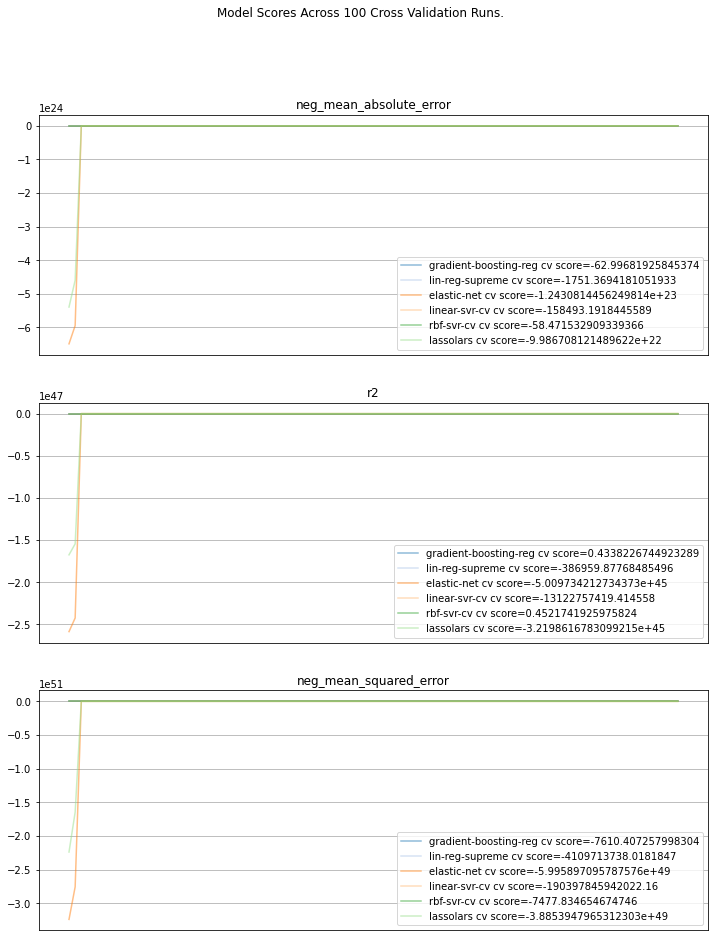

In [17]:
vbhelper.plotCVScores(sort=1)

In [18]:
vbhelper.predictCVYhat()

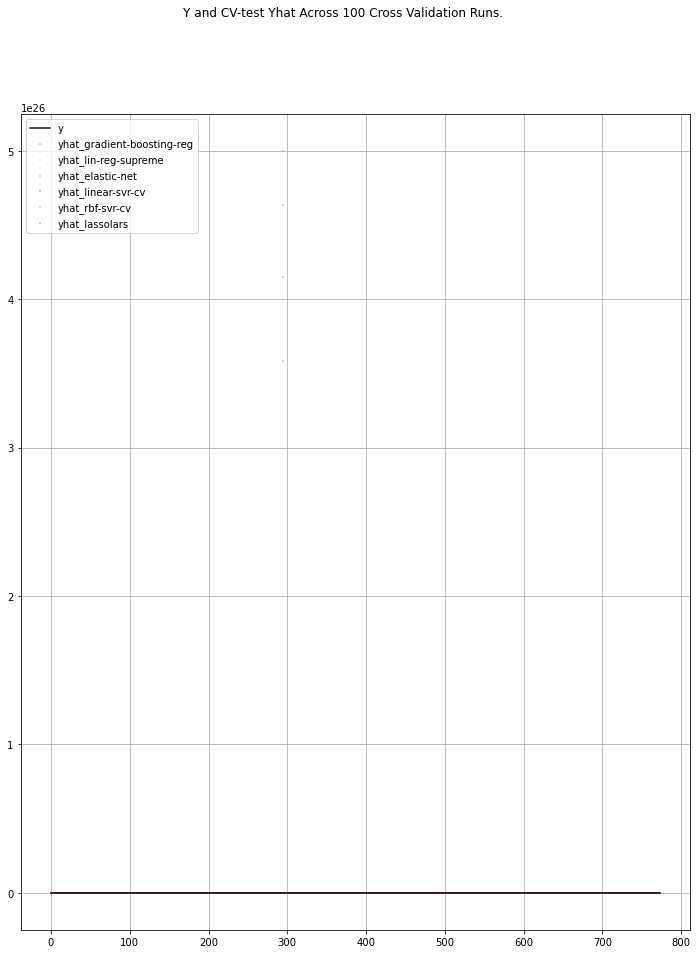

In [19]:
vbhelper.plotCVYhat(single_plot=True)

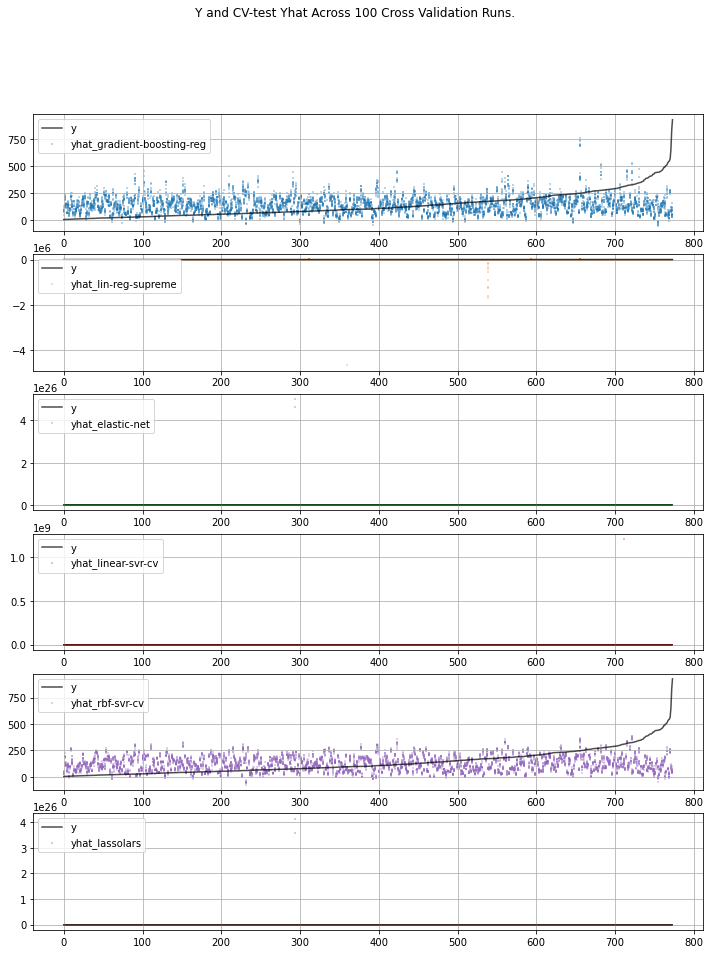

In [20]:
vbhelper.plotCVYhat(single_plot=False)